<a href="https://colab.research.google.com/github/OluwolePalmer/Glaucoma-Detection-Using-OCT-SLO-Fundus-Images/blob/main/OCT%20Fundus_Predict_Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Deep Learning Model That can Predict if a Patient has Glaucoma by Analyzing OCT Fundus Images**

An estimated 64 million people worldwide suffer from glaucoma according to World Health Organization (WHO). To aid in the detection of this disease, this project explores glaucoma pattern-recognition using deep learning (DL) to analyse Optical Coherence Tomography (OCT) and Scanning Laser Ophthalmoscopy (SLO) fundus images.

Fundus imaging is the most used screening technique for glaucoma detection for its trade-off between portability, size and costs. By detecting subtle thinning of the retinal nerve fiber layer (RNFL) with OCT, glaucoma can be identified at earlier stages when treatment is most effective.

**Method**

The method adopted in this project is feature learning based on deep convolutional neural network (CNN). The overview is shown in the figure below. The CNN contains six layers: five multilayer perceptron convolutional layers and a fully connected layer. The model was trained with 3000 fundus images (OCT).

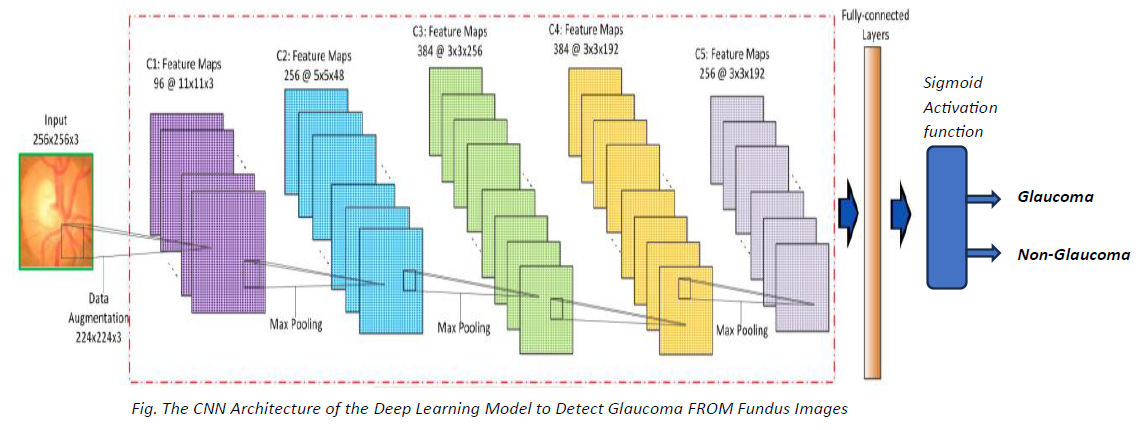

**I acknowledge the support and guidance of Dr. Min Shi** on this project. His notes were very instructive and it was a rare opportunity for me to learn from him.

**1. Import relevant libraries and packages**

In [ ]:
# %pip install tensorflow
# %pip install opencv-contrib-python
# %pip install utils
# %pip install import_ipynb

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import random
import cv2
from utils import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from copy import deepcopy

**2. Load data**

In [ ]:
folder = 'C:\\Users\\HP\\OneDrive - University of Louisiana Lafayette\\Documents\\Louisiana\\3. Fall 2024\\CSCE 566 - Data Mining\\Final Project\\Datasets\\Problem_5_Glaucoma_Detection_using_SLO_and_OCT_Fundus_Images'

data_summary = pd.read_csv(os.path.join(folder, 'data_summary.csv'))
data_summary

,filename,age,gender,race,ethnicity,language,maritalstatus,md,glaucoma,use
0,data_00001.npz,72.37,female,white,non-hispanic,english,widowed,-22.93,yes,training
1,data_00002.npz,62.09,female,white,non-hispanic,english,divorced,1.48,no,training
2,data_00003.npz,68.70,female,white,non-hispanic,english,married or partnered,-19.61,yes,training
3,data_00004.npz,57.07,female,white,non-hispanic,english,married or partnered,1.13,no,training
4,data_00005.npz,47.59,male,white,non-hispanic,english,single,0.44,no,training
...,...,...,...,...,...,...,...,...,...,...
4995,data_09996.npz,59.12,female,white,non-hispanic,english,married or partnered,0.16,no,testing
4996,data_09997.npz,62.00,female,white,non-hispanic,english,married or partnered,0.41,no,testing
4997,data_09998.npz,77.10,female,white,non-hispanic,english,widowed,-9.54,yes,testing
4998,data_09999.npz,44.76,female,white,non-hispanic,english,married or partnered,0.74,no,testing


In [ ]:
flist = os.listdir(os.path.join(folder, 'Training'))
print(len(flist))

3000


In [ ]:
sample_data = np.load(os.path.join(folder, 'Training', flist[0]))
for i in sample_data.keys():
    print(i)

oct_fundus
slo_fundus
age
gender
race
ethnicity
language
marriagestatus
md
glaucoma


In [ ]:
sample_data['oct_fundus'], sample_data['slo_fundus']

(array([[197, 182, 177, ..., 170, 152, 147],
        [193, 191, 189, ..., 146, 135, 138],
        [184, 191, 197, ..., 150, 149, 141],
        ...,
        [189, 185, 188, ..., 192, 186, 187],
        [192, 186, 185, ..., 200, 191, 191],
        [169, 195, 191, ..., 198, 189, 187]], dtype=uint8),
 array([[25, 27, 20, ..., 20, 29, 11],
        [16, 26, 23, ..., 19, 14,  5],
        [21, 22, 23, ..., 14,  9, 11],
        ...,
        [22, 32, 39, ..., 11,  4, 10],
        [47, 35, 43, ..., 15,  5,  7],
        [25, 22, 32, ..., 11,  5, 14]], dtype=uint8))

**Fundus viewer**: This is a function to view the fundus images.

In [ ]:
def gen_cmap(N=10000):

    return matplotlib.colors.LinearSegmentedColormap.from_list("", [(0,'black'), (0.06,'blue'),
                                                                  (0.23, '#2ab6c6'), (0.38,'yellow'),
                                                                  (0.6,'red'), (1,'white')], N=N)



def plot_2dmap(img, show_colorbar=True, show_cup=False, with_ref=False, ref_img=None, delartifact=False, cm=None, title_on=True):
    if cm == None:
        cm = gen_cmap(256)

    img_copy2d = deepcopy(img)
    # mark the rim and cup regions by -1 and -2 locations
    if show_cup:
        img_copy2d[img_copy2d==-1] = np.nan
        cm.set_bad("gray")
        cm.set_under(color='lightgray')
    # mark rim and cup regions from reference img
    if with_ref:
        img_copy2d[ref_img==-2] = -2
        img_copy2d[ref_img==-1] = np.nan
        cm.set_bad(color="gray")
        cm.set_under(color='lightgray')
    # delete artifact locations defined by <=30 and >=0
    if delartifact:
        img_copy2d[(img_copy2d<=30) & (img_copy2d>0)] = 0
    fig = plt.figure()
    ax = plt.subplot(111)
    img_copy2d = ax.imshow(img_copy2d, cmap=cm, vmin=-0.00000001, vmax=350)
    if show_colorbar:
        cbar = plt.colorbar(img_copy2d, pad=0.01, aspect=12, location='left')
        cbar.set_ticks([0, 175,350])
        cbar.ax.set_yticklabels(['0 μm', '175 μm', '350 μm'])
        cbar.ax.tick_params(labelsize=14)
        if title_on:
            ax.set_title('RNFL Thickness Map', fontsize=15)
        ax.axis('off')
    else:
        ax.axis('off')
    plt.show()

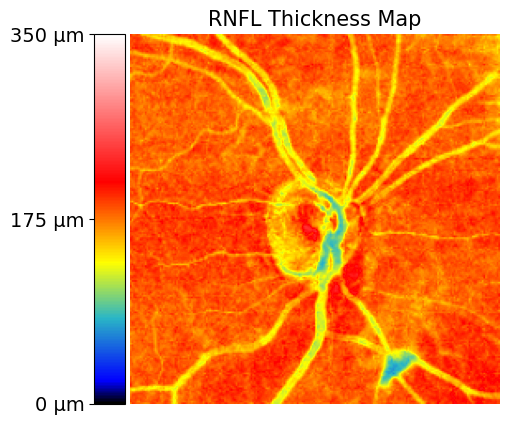

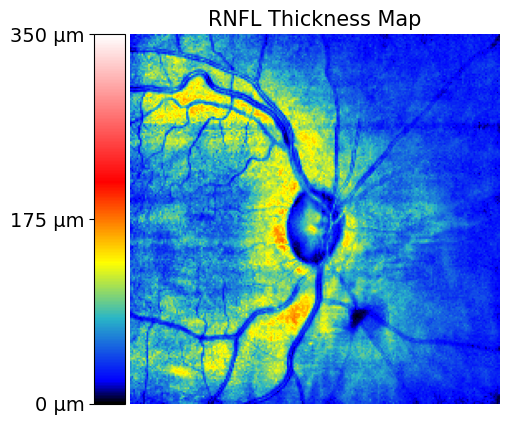

(None, None)

In [ ]:
plot_2dmap(sample_data['oct_fundus'], show_cup=False), plot_2dmap(sample_data['slo_fundus'], show_cup=False)

**Data loader**

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, flist, data_path, batch_size=8, dim=(256,256), n_channels=3, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = flist
        self.data_path = data_path
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size), dtype=np.int32)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            data = np.load(os.path.join(self.data_path, ID))
            img = cv2.resize(data['oct_fundus'], (224,224))
            X[i,] =  np.transpose(np.array([img, img, img]), (1, 2, 0))
            y[i] = data['glaucoma']

            # # Process the first image
            # img1 = cv2.resize(data['oct_fundus'], (self.dim[1], self.dim[0]))
            # img1 = np.transpose(np.array([img1, img1, img1]), (1, 2, 0))

            # # Process the second image
            # img2 = cv2.resize(data['slo_fundus'], (self.dim[1], self.dim[0]))
            # img2 = np.transpose(np.array([img2, img2, img2]), (1, 2, 0))

            # # Store both images in X
            # X[i, 0,] = img1
            # X[i, 1,] = img2
            # Store the label
            # y[i] = data['glaucoma']

        return X, y

**Test the data loader**

In [ ]:
image_folder = os.path.join(folder, 'Training')

_generator = DataGenerator(flist, image_folder,
                           batch_size=4, dim=(224,224),
                           n_channels=3, shuffle=True)

In [ ]:
imgs, labs = _generator.__getitem__(0)
len(imgs), labs

(4, array([1, 0, 0, 1]))

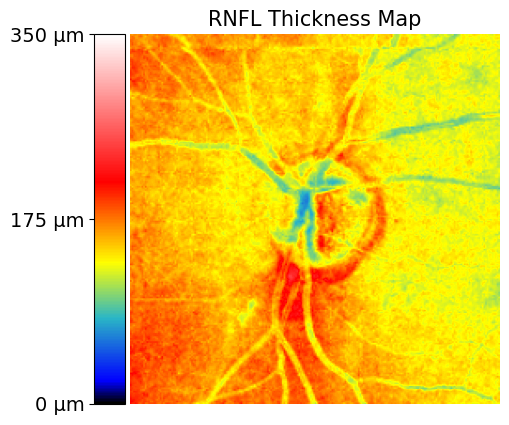

In [ ]:
plot_2dmap(imgs[0][:,:,2])

**2. Define the deep learning model**

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout


def build_model(img_size=224, channel=3):
    img = Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.efficientnet.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_tensor=img,
        pooling=None)

    model.trainable = True

    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x, training=True)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model_cls = Model(inputs=model.input, outputs=output_layer)
    return model_cls



def build_model(img_size=224, channel=3):
    img = Input(shape=(img_size, img_size, 3), name="input")
    model = tf.keras.applications.vgg16.VGG16(
                               weights='imagenet',
                               include_top=False)

    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x, training=True)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model_cls = Model(inputs=model.input, outputs=output_layer)
    return model_cls

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**3. Train the model**

In [ ]:
batch_size = 100

In [ ]:
train_generator = DataGenerator(flist, image_folder,
                                   batch_size=batch_size, dim=(224, 224),
                                   n_channels=3, shuffle=True)

model = build_model()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy',
                                     metrics = ['acc', tf.keras.metrics.AUC()])

history = model.fit(train_generator,
                    steps_per_epoch = int(len(flist)/batch_size),
                    epochs = 2)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3424s 114s/step - acc: 0.5425 - auc: 0.5216 - loss: 1.0577
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3414s 114s/step - acc: 0.6485 - auc: 0.6553 - loss: 0.6484


**4. Evaluate the model**

To evaluate the performance, the model was used to analyse 2,000 fundus images (testing set) as shown in the following code blocks.

In [ ]:
path_attr_map = {}
for index, row in data_summary.iterrows():
    # path_attr_map[row['filename']+'.npz'] = [row['race'], row['ethnicity'], row['gender']]
    path_attr_map[row['filename']] = [row['race'], row['ethnicity'], row['gender']]

In [ ]:
flist_test = os.listdir(os.path.join(folder, 'Testing'))
test_folder = os.path.join(folder, 'Testing')

In [ ]:
test_generator = DataGenerator(flist_test, test_folder,
                               batch_size=batch_size, dim=(224,224),
                               n_channels=3, shuffle=True)

test_y = []
pred_y = []
test_paths = []
test_attrs = []
indexes = np.arange(len(flist_test))
for i in range(test_generator.__len__()):
    batch_X, batch_y = test_generator.__getitem__(i)
    pred_batch_y = model.predict(batch_X, verbose=0)
    test_y.extend(batch_y)
    pred_y.extend(np.squeeze(pred_batch_y))
    test_paths.extend([flist_test[idx] for idx in indexes[i*batch_size:(i+1)*batch_size]])
    test_attrs.extend([path_attr_map[flist_test[idx]] for idx in indexes[i*batch_size:(i+1)*batch_size]])

# # perfs = eval_test(test_y, pred_y, test_attrs)

The **confusion matrix** summarizes the performance of the model on the test set:

TP = 986

FP = 577

TN = 310

FN = 127

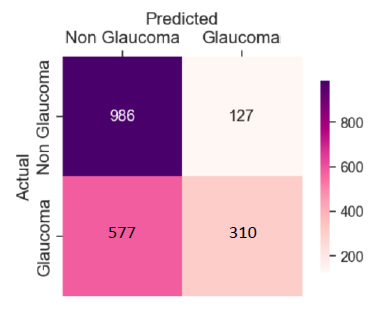

**Overall performance**

In [ ]:
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import auc, confusion_matrix

def cal_auc(test_y, pred_y, msg='Overall'):
    test_y = np.array(test_y)
    test_pred = np.array(pred_y)

    fpr, tpr, thresholds = roc_curve(test_y, test_pred)
    Auc = auc(fpr, tpr)

    print(msg, Auc)

    return Auc

In [ ]:
auc_overall = cal_auc(test_y, pred_y, 'Overall')
print(auc_overall)

Overall 0.709931110348034
0.709931110348034


0.709931110348034 0.648 
 [[986 127]
 [577 310]]


C:\Users\HP\AppData\Local\Temp\ipykernel_4700\3601941004.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red')


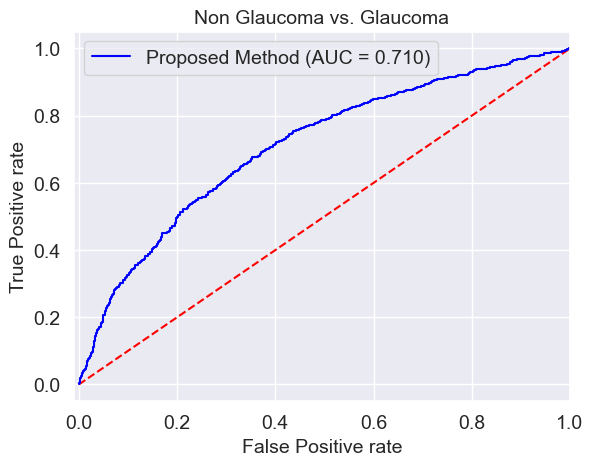

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc_score = auc(fpr, tpr)
acc = accuracy_score(test_y, np.rint(pred_y))
cfmat = confusion_matrix(test_y, np.rint(pred_y))
print(auc_score, acc, '\n', cfmat)


plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot([0, 1], [0, 1], 'k--', color='red')
plt.plot(fpr, tpr, label='Proposed Method (AUC = {:.3f})'.format(auc_score), color='blue')
plt.xlim([-0.01, 1.0])
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.xlabel('False Positive rate', fontsize=14)
plt.ylabel('True Positive rate', fontsize=14)
plt.title('Non Glaucoma vs. Glaucoma', fontsize=14)
plt.legend(loc='best', fontsize=14)
# plt.show()

# plt.savefig('results/roc_curve.jpg',
#             dpi=600,
#             orientation='portrait',
#             bbox_inches='tight', pad_inches=0)

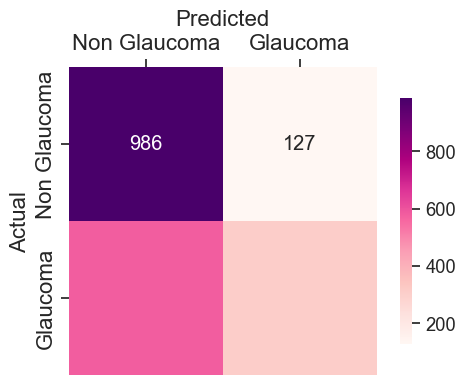

In [ ]:
# Create the Confusion Matrix

# Create the figure
fig6 = plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)

# Generate heatmap
y = ['Non Glaucoma', 'Glaucoma']
ax = sns.heatmap(cfmat, annot=True, cmap='RdPu', fmt="d", square=True, xticklabels=y, yticklabels=y, cbar_kws={"shrink": 0.8})
# ax = sns.heatmap(cfmat, annot=True ,vmin=0, vmax=90, square=True, xticklabels=y, yticklabels=y, cmap='RdPu', fmt="d", cbar_kws={"shrink": 0.8})
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.set_xticklabels(y, fontsize=16)
ax.set_yticklabels(y, fontsize=16)
plt.title("Predicted", fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.yticks(rotation=90)
plt.xticks(rotation=0)

# Displays the heatmap
plt.show()

**Subgroup performance**

In [ ]:
test_y_race = {'White':[], 'Black':[], 'Asian':[]}
pred_y_race = {'White':[], 'Black':[], 'Asian':[]}
test_y_hispanic = {'Non_hispanic':[], 'Hispanic':[]}
pred_y_hispanic = {'Non_hispanic':[], 'Hispanic':[]}
test_y_gender = {'Female':[], 'Male':[]}
pred_y_gender = {'Female':[], 'Male':[]}


for i in range(len(test_attrs)):
    params = test_attrs[i]

    race = str(params[0])
    ethinicity = str(params[1])
    gender = str(params[2])

    if race == 'White'.lower():#7:
        test_y_race['White'].append(test_y[i])
        pred_y_race['White'].append(pred_y[i])
    elif race == 'Black or African American'.lower():#2:
        test_y_race['Black'].append(test_y[i])
        pred_y_race['Black'].append(pred_y[i])
    elif race == 'Black'.lower():#2:
        test_y_race['Black'].append(test_y[i])
        pred_y_race['Black'].append(pred_y[i])
    elif race == 'Asian'.lower():#3:
        test_y_race['Asian'].append(test_y[i])
        pred_y_race['Asian'].append(pred_y[i])

    if ethinicity == 'non-hispanic':
        test_y_hispanic['Non_hispanic'].append(test_y[i])
        pred_y_hispanic['Non_hispanic'].append(pred_y[i])
    elif ethinicity == 'hispanic':
        test_y_hispanic['Hispanic'].append(test_y[i])
        pred_y_hispanic['Hispanic'].append(pred_y[i])

    if gender == 'female':
        test_y_gender['Female'].append(test_y[i])
        pred_y_gender['Female'].append(pred_y[i])
    elif gender == 'male':
        test_y_gender['Male'].append(test_y[i])
        pred_y_gender['Male'].append(pred_y[i])

In [ ]:
for k in test_y_gender.keys():
    auc_gender = cal_auc(test_y_gender[k], pred_y_gender[k], k)

Female 0.701589796265118
Male 0.7339997334399574


In [ ]:
for k in test_y_hispanic.keys():
    auc_gender = cal_auc(test_y_hispanic[k], pred_y_hispanic[k], k)

Non_hispanic 0.7105154639175257
Hispanic 0.6968272620446534


In [ ]:
for k in test_y_race.keys():
    auc_gender = cal_auc(test_y_race[k], pred_y_race[k], k)

White 0.7080727964525019
Black 0.7264287001983054
Asian 0.7


**5. Save the model**

In [ ]:
model.save(f"results/oct_predict_glaucoma_model.h5")
np.savez(f"results/oct_predict_glaucoma_model.npz",
         test_y=test_y,
         test_pred=pred_y,
         test_attrs=test_attrs,
         test_paths=test_paths)



---

**References**

1. Shinde R. Glaucoma detection in retinal fundus images using u-net and supervised machine learning algorithms. Intell-Based Med. 2021;5:100038. doi: 10.1016/j.ibmed.2021.100038. [DOI](https://www.sciencedirect.com/science/article/pii/S2666521221000144?via%3Dihub) [Google Scholar](https://scholar.google.com/scholar_lookup?journal=Intell-Based%20Med.&title=Glaucoma%20detection%20in%20retinal%20fundus%20images%20using%20u-net%20and%20supervised%20machine%20learning%20algorithms&author=R.%20Shinde&volume=5&publication_year=2021&pages=100038&doi=10.1016/j.ibmed.2021.100038&)
2. Sreng S., Maneerat N., Hamamoto K., Win K.Y. Deep Learning for Optic Disc Segmentation and Glaucoma Diagnosis on Retinal Images. Appl. Sci. 2020;10:4916. doi: 10.3390/app10144916. [DOI](https://www.mdpi.com/2076-3417/10/14/4916) [Google Scholar](https://scholar.google.com/scholar_lookup?journal=Appl.%20Sci.&title=Deep%20Learning%20for%20Optic%20Disc%20Segmentation%20and%20Glaucoma%20Diagnosis%20on%20Retinal%20Images&author=S.%20Sreng&author=N.%20Maneerat&author=K.%20Hamamoto&author=K.Y.%20Win&volume=10&publication_year=2020&pages=4916&doi=10.3390/app10144916&)
3. Chen X., Xu Y., Yan S., Wong D.W.K., Wong T.Y., Liu J. Automatic feature learning for glaucoma detection based on deep learning. MICCAI. 2015;9351:669–677. [Google Scholar](https://scholar.google.com/scholar_lookup?journal=MICCAI&title=Automatic%20feature%20learning%20for%20glaucoma%20detection%20based%20on%20deep%20learning&author=X.%20Chen&author=Y.%20Xu&author=S.%20Yan&author=D.W.K.%20Wong&author=T.Y.%20Wong&volume=9351&publication_year=2015&pages=669-677&)
4. Raghavendra U., Fujita H., Bhandary S.V., Gudigar A., Tan J.H., Acharya U.R. Deep convolution neural network for accurate diagnosis of glaucoma using digital fundus images. J. Inf. Sci. 2018;441:41–49. doi: 10.1016/j.ins.2018.01.051. [DOI](https://www.sciencedirect.com/science/article/abs/pii/S0020025518300744?via%3Dihub) [Google Scholar](https://scholar.google.com/scholar_lookup?journal=J.%20Inf.%20Sci.&title=Deep%20convolution%20neural%20network%20for%20accurate%20diagnosis%20of%20glaucoma%20using%20digital%20fundus%20images&author=U.%20Raghavendra&author=H.%20Fujita&author=S.V.%20Bhandary&author=A.%20Gudigar&author=J.H.%20Tan&volume=441&publication_year=2018&pages=41-49&doi=10.1016/j.ins.2018.01.051&)